In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [5]:
# --- Import Standard Libraries ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import copy
import yaml
from tqdm.notebook import tqdm
import itertools

# --- Import our custom modules ---
# Use autoreload to pick up changes in .py files without restarting kernel
%load_ext autoreload
%autoreload 2

from q2reg import regularizers
from q2reg import training
from q2reg import utils_landscape
from q2reg import utils_math

from bitbybit import networks, environments, utils, viz_utils

# --- Matplotlib Aesthetics Settings ---
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    'grid.alpha': 0.5,
    'grid.color': '#c0c0c0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.dpi': 300,
    'figure.edgecolor': 'black',
    'figure.facecolor': 'white',
    'figure.figsize': [6, 5],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")

Running on cuda:0


Load artifacts saved

In [13]:
def load_task_geometry(exp_dir, task_id=0):
    """
    Reconstructs the Anchor and Fisher from saved regularizer artifacts.
    """
    artifact_dir = os.path.join(exp_dir, 'artifacts', f'task_{task_id}')
    
    # 1. Load Anchors (List of tensors)
    anchors = torch.load(os.path.join(artifact_dir, 'anchors.pt'))
    current_anchor = anchors[-1].to(device) # Get the most recent one
    
    # 2. Load Samples (List of tuples)
    samples = torch.load(os.path.join(artifact_dir, 'samples.pt'))
    
    # Convert list of tuples back to batched tensor
    # Note: These are the accumulated samples up to this task
    xs = torch.cat([s[0] for s in samples]).to(device)
    ys = torch.cat([s[1] for s in samples]).to(device)
    
    # 3. Re-init Model Structure (to load weights)
    config_path = os.path.join(exp_dir, 'config.yaml')
    with open(config_path) as f: cfg = yaml.safe_load(f)
    model = networks.get_network_from_name(cfg['network']['name'], **cfg['network']).to(device)
    
    # Set model weights to the anchor
    # We need a helper to load flat params back into state_dict
    utils.set_flat_params(model, current_anchor)
    
    # 4. Recompute Full Fisher
    print(f"Recomputing Fisher on {len(xs)} samples...")
    loss_fn = torch.nn.CrossEntropyLoss()
    
    _, _, F_full = utils_math.compute_loss_grad_curvature(
        model, loss_fn, xs, ys, curvature_type='fisher'
    )
    
    return model, (xs, ys), F_full, cfg

In [14]:
exp_dir = "../q2reg/results/study_q2approx_v1/training_mode_regularized-reg_type_full-curvature_type_fisher-accumulate_True-no_grad-alpha_1.0/seed_13"
model, data, F, config = load_task_geometry(exp_dir, task_id=0)

Number of parameters 0.000502 MLN
Recomputing Fisher on 10 samples...


Probing the geometry

In [50]:
def probe_geometry(model, data, loss_fn, steps=30, range_val=1.0):
    """
    Computes Loss, Fisher Norm, and Fisher Distance along specific directions.
    """
    # 1. Prepare Data (Full Batch)
    x, y = data
    x, y = x.to(device), y.to(device)
    
    # 2. Compute Center Geometry (F_0)
    # We use Fisher because that's what we are regularizing with
    l_0, g_flat, F_0 = utils_math.compute_loss_grad_curvature(model, loss_fn, x, y, curvature_type='fisher')
    
    # 3. Define Directions
    # Top Eigenvector
    v_top = utils_landscape.get_top_eigenvectors(F_0, k=1, structure='full')[0]
    
    # Bottom Eigenvector
    L, V = torch.linalg.eigh(F_0)
    v_bot = V[:, 0]
    
    # Random Direction
    v_rand = torch.randn_like(v_top)
    v_rand /= v_rand.norm()
    
    # Gradient Direction (Normalized)
    # This is interesting: Does the Fisher change fast in the direction of the gradient?
    v_grad = g_flat / g_flat.norm()

    directions = {
        'Top Eigenvector (High Curv)': v_top,
        'Bottom Eigenvector (Flat)': v_bot,
        'Random Direction': v_rand,
        # 'Gradient Direction': v_grad
    }
    
    # 4. Walk the paths
    epsilons = np.linspace(-range_val, range_val, steps)
    base_params = utils.get_flat_params(model)
    
    logs = {k: {'loss': [], 'fisher_diff': [], 'fisher_trace': []} for k in directions}
    
    print("Probing geometry...")
    for name, v in directions.items():
        for eps in epsilons:
            # Move
            new_params = base_params + (eps * v)
            
            # Compute Geometry at new point
            l_eps, _, F_eps = utils_math.compute_loss_grad_curvature(
                model, loss_fn, x, y, params_flat=new_params, curvature_type='fisher'
            )
            
            # Metrics
            logs[name]['loss'].append(l_eps.item())
            logs[name]['fisher_diff'].append(torch.norm(F_eps, p=2).item()-torch.norm(F_0, p=2).item() )
            logs[name]['fisher_trace'].append(torch.trace(F_eps).item())
            
    return epsilons, logs

# Run it


Visualization

In [57]:
def plot_stability_analysis(epsilons, logs):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300)
    
    colors = {'Top Eigenvector (High Curv)': 'red', 
              'Bottom Eigenvector (Flat)': 'green', 
              'Random Direction': 'gray',
              'Gradient Direction': 'blue'}
    
    # Plot 1: Loss Landscape
    ax = axes[0]
    for name, data in logs.items():
        ax.plot(epsilons, data['loss'], label=name, color=colors.get(name, 'black'), lw=2)
    ax.set_title("Loss Landscape Slice")
    ax.set_ylabel("True Loss")
    ax.set_xlabel("Step Size (eps)")
    ax.legend()
    ax.grid()
    
    # Plot 2: Fisher Stability (Hypothesis Test)
    ax = axes[1]
    for name, data in logs.items():
        ax.plot(epsilons, data['fisher_diff'], label=name, color=colors.get(name, 'black'), lw=2)
    ax.set_title("Geometric Instability\n($||F_{\epsilon}||_2 - ||F_0||_2$)")
    ax.set_ylabel("Change in Fisher Matrix")
    ax.set_xlabel("Step Size (eps)")
    ax.grid()
    
    # Plot 3: Curvature Magnitude
    ax = axes[2]
    for name, data in logs.items():
        ax.plot(epsilons, data['fisher_trace'], label=name, color=colors.get(name, 'black'), lw=2)
    ax.set_title("Local Curvature Intensity\n(Trace($F_{\epsilon}$))")
    ax.set_ylabel("Total Curvature")
    ax.set_xlabel("Step Size (eps)")
    ax.grid()
    
    plt.tight_layout()
    plt.show()

Probing geometry...


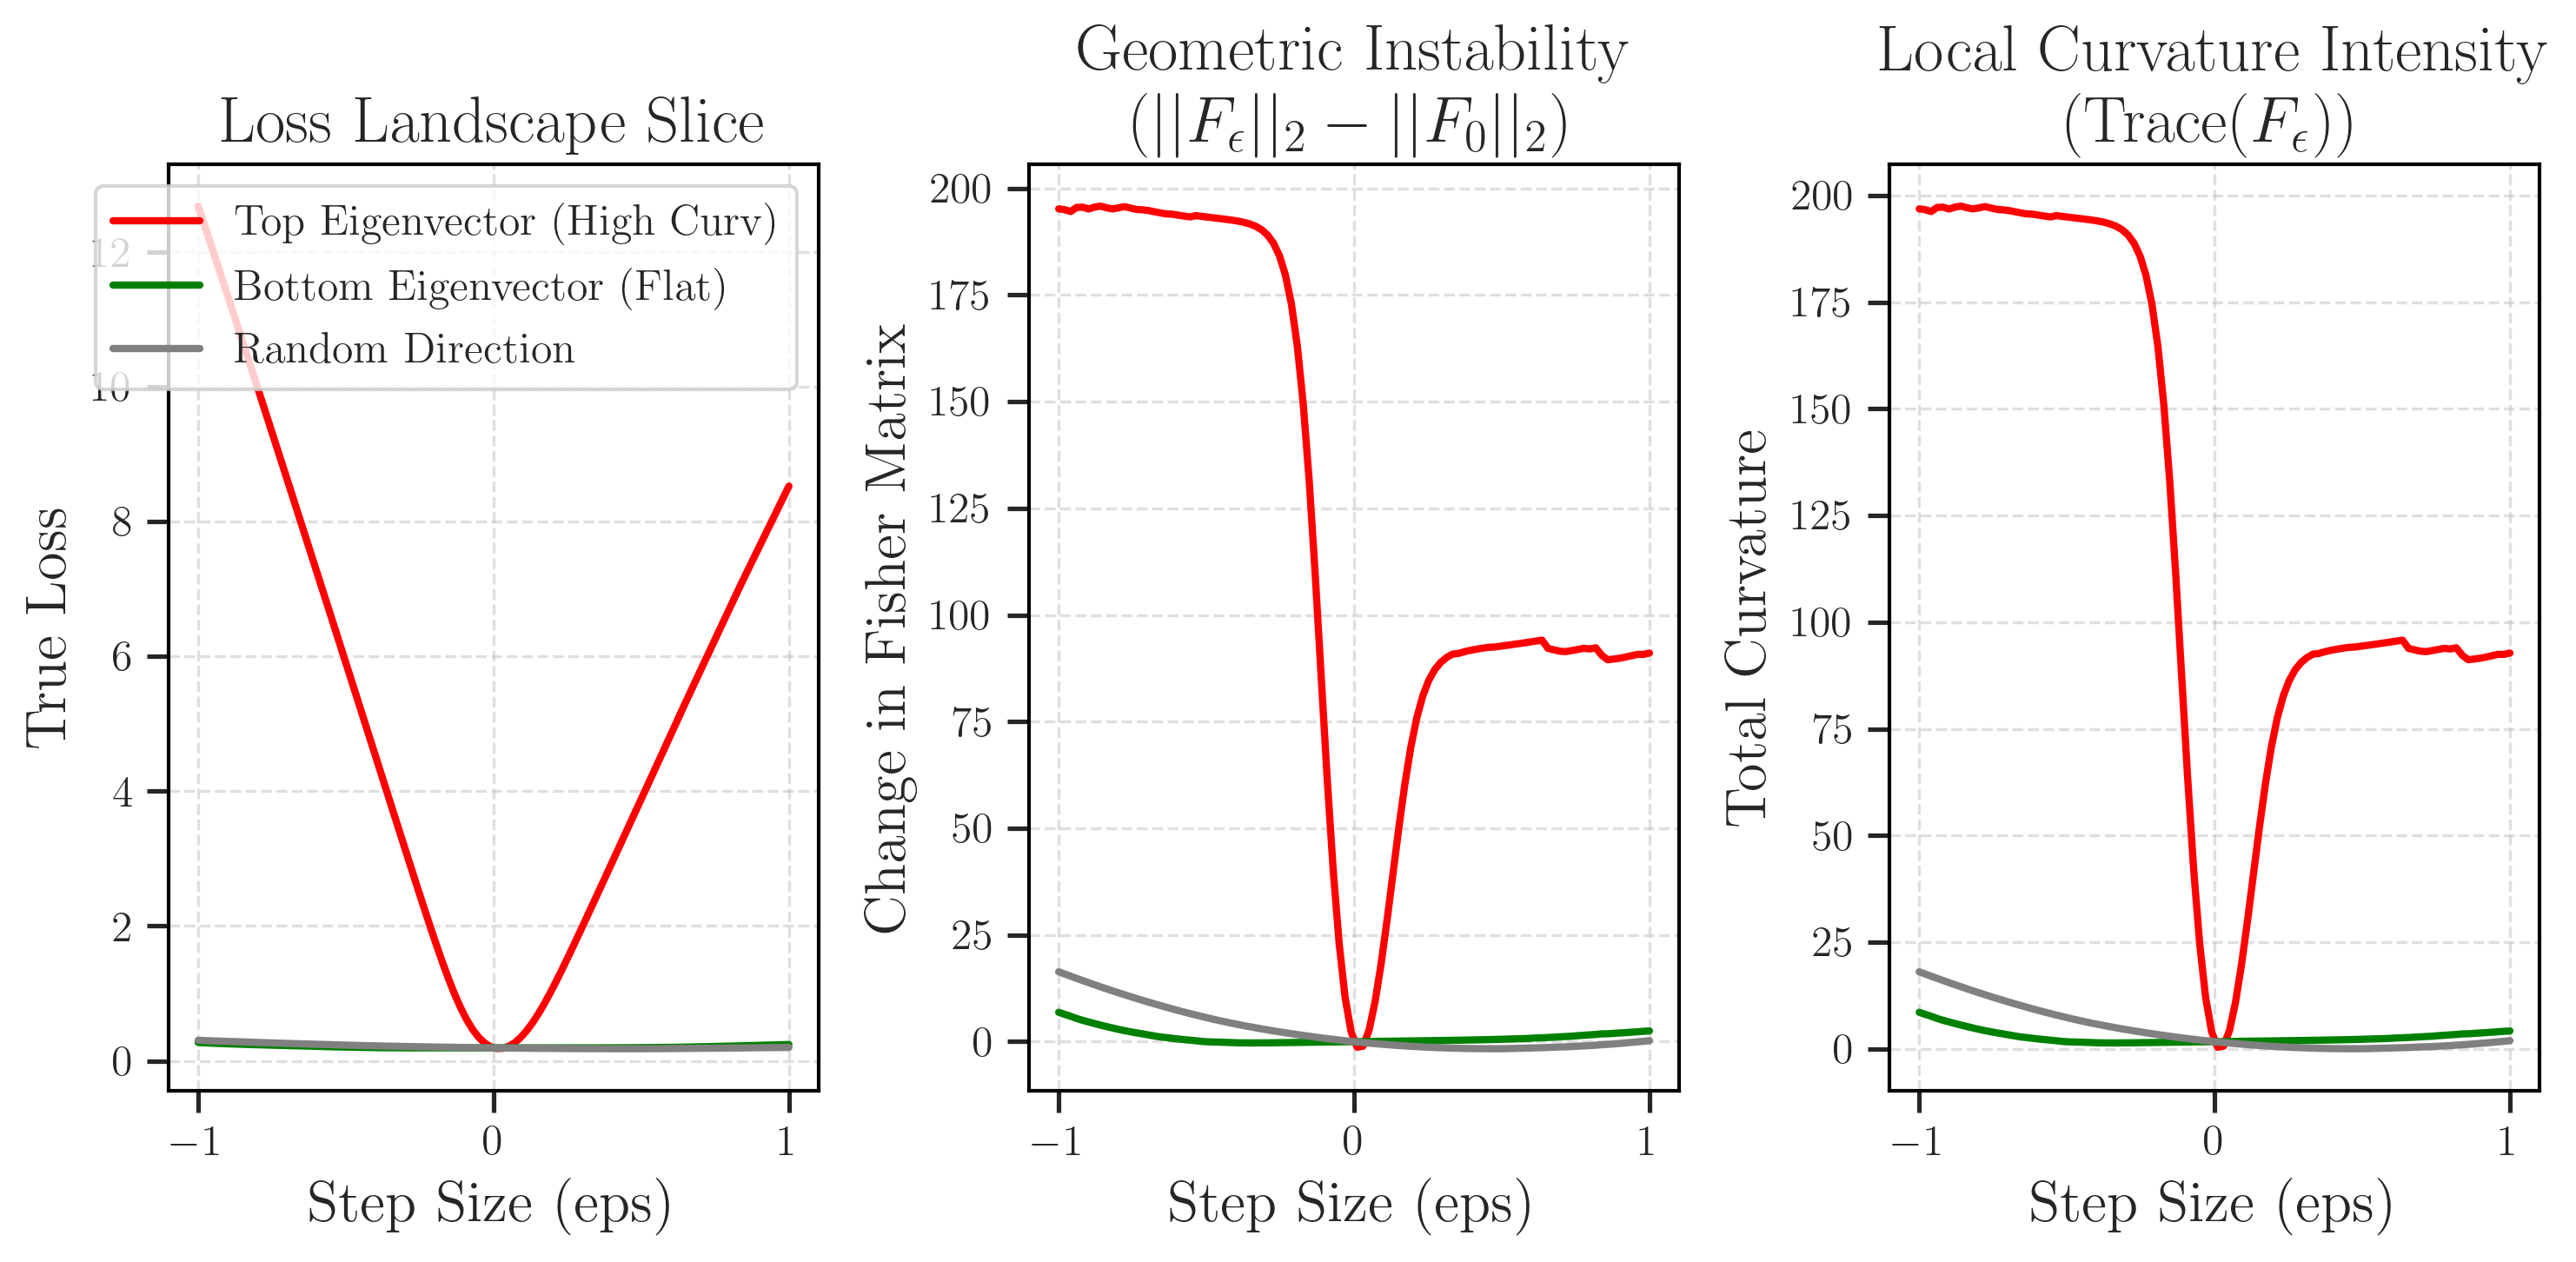

In [60]:
loss_fn = lambda o, t: utils.loss_fn(o, t, config['loss'])
epsilons, logs = probe_geometry(model, data, loss_fn, steps=100, range_val=1.0)
plot_stability_analysis(epsilons, logs)

Probing geometry...


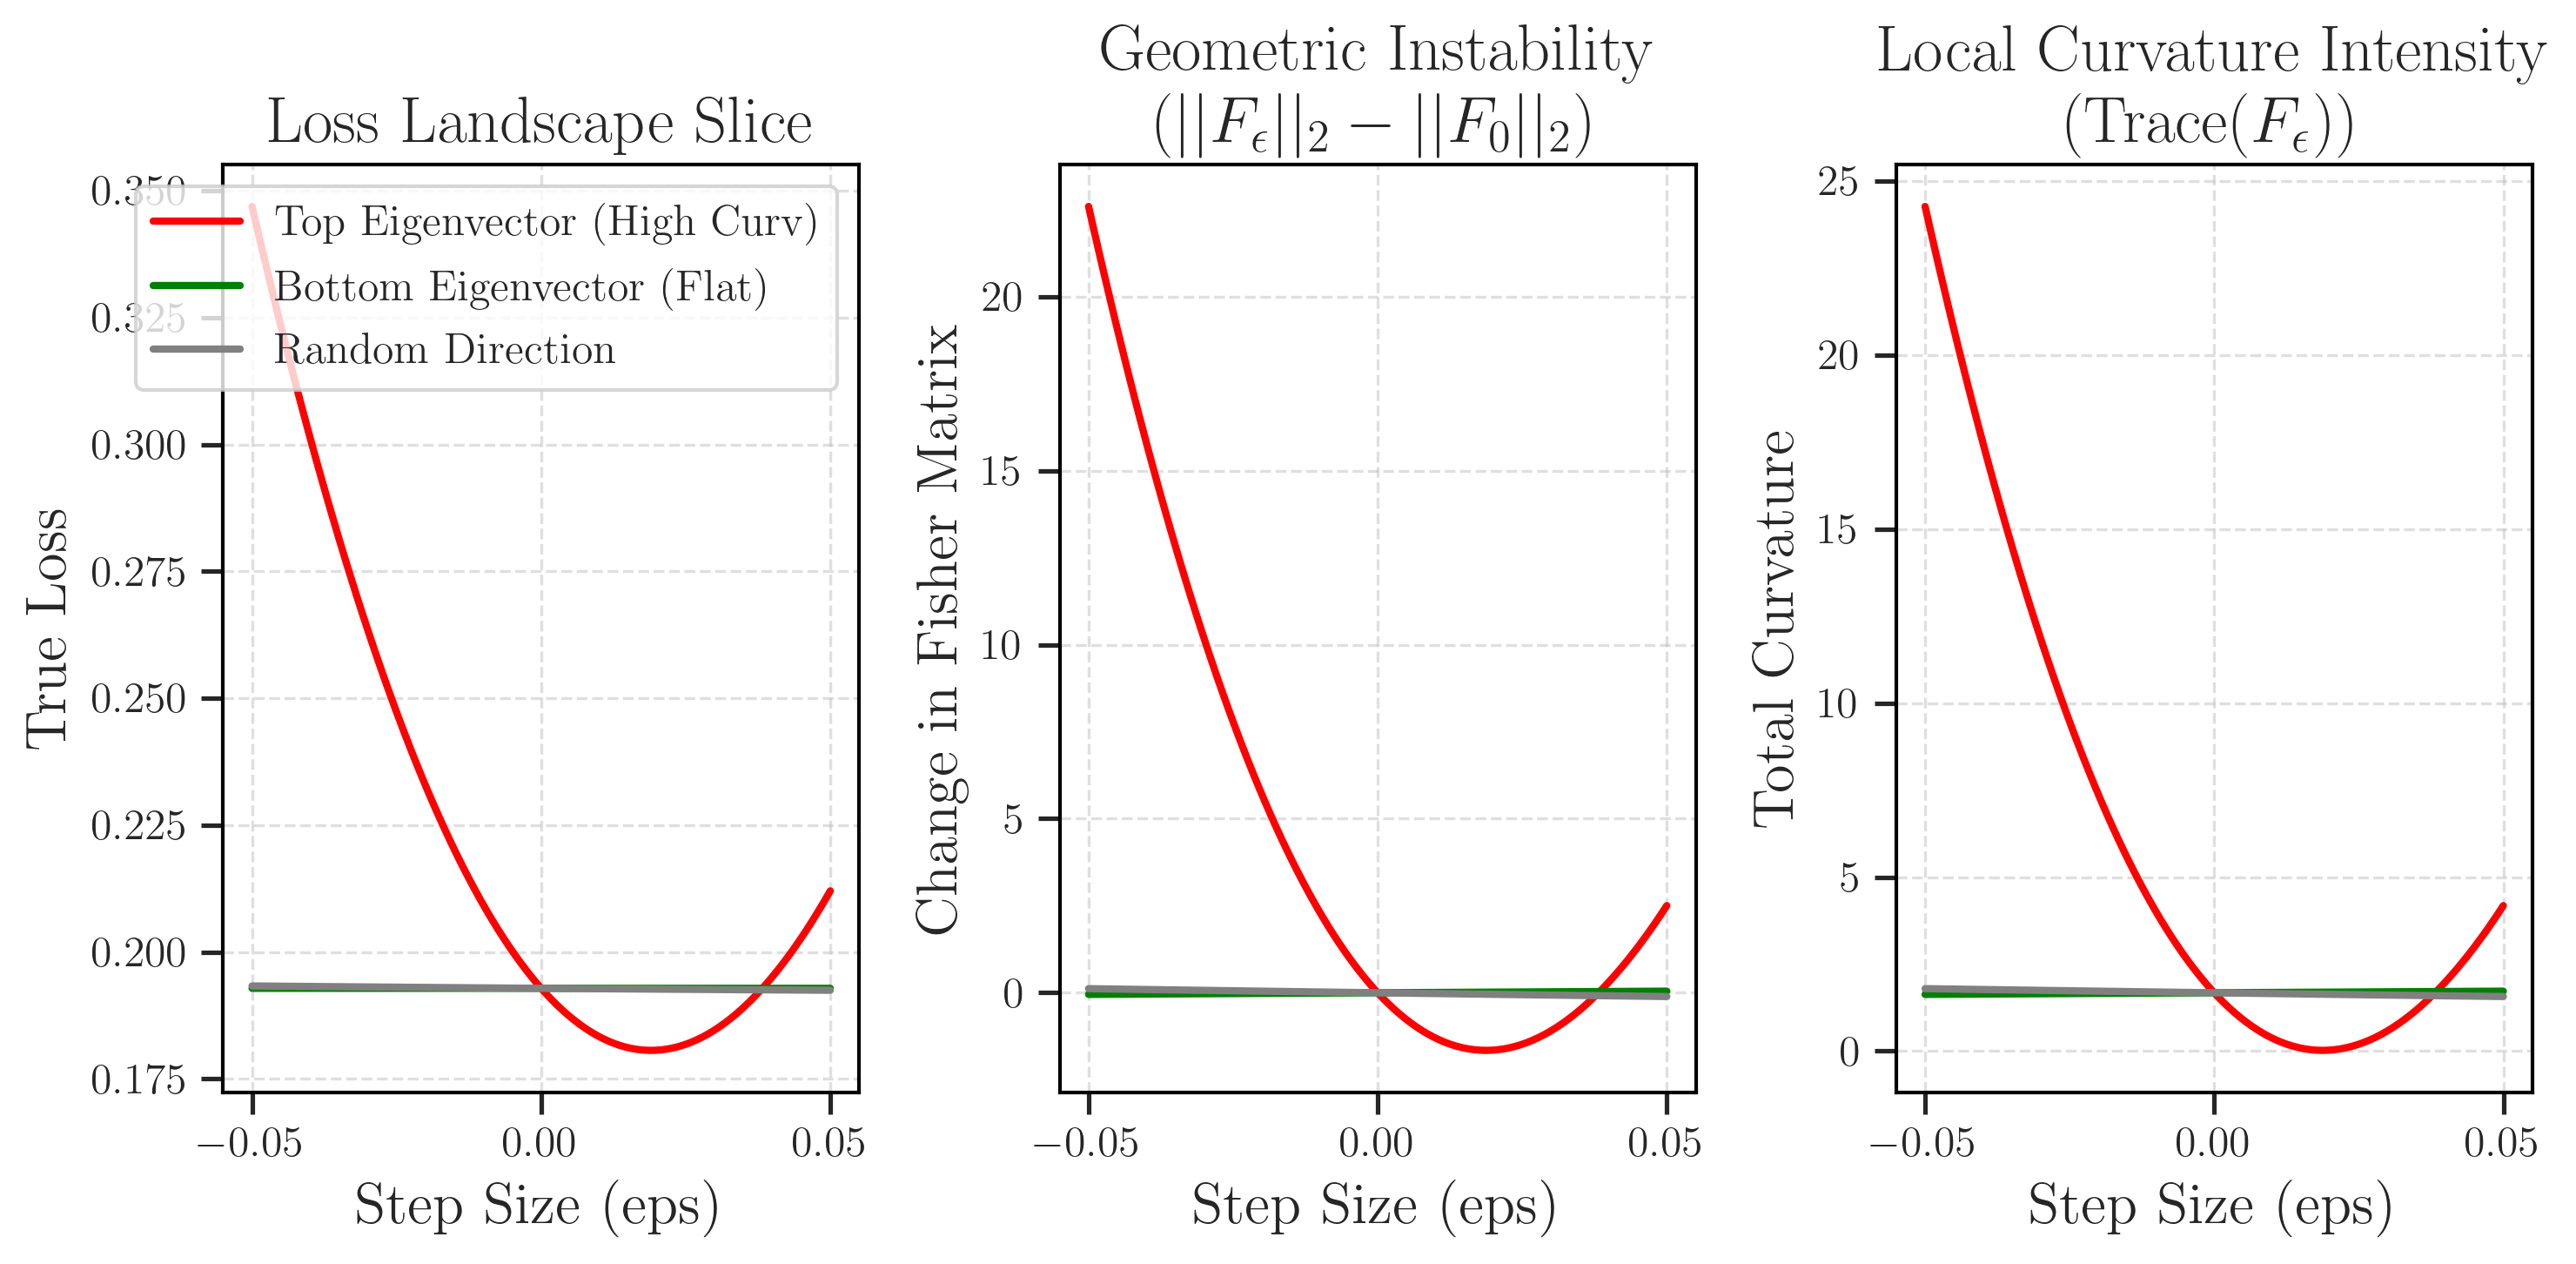

In [59]:
loss_fn = lambda o, t: utils.loss_fn(o, t, config['loss'])
epsilons, logs = probe_geometry(model, data, loss_fn, steps=100, range_val=.05)
plot_stability_analysis(epsilons, logs)